In [1]:
import numpy as np
import pandas as pd
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from useful.eda import basic_info

##### Function to clean up the headings/index

In [2]:
def load_data(df):
    new_index = df.reset_index()
    new_header = new_index.iloc[0] #identify a new header
    new_data = new_index[1:] #chop off top two rows
    new_data_index = new_data.reset_index(drop=True) #reset again
    new_data_index.columns = new_header

    return new_data_index

##### bring in two data sets for combination - one with combine data & one w/game stats

In [3]:
wr_combine_data = pd.read_csv(('./data/wr_combine_data.csv'))
wr_data = load_data(pd.read_csv(('./data/wr_data.csv')))


In [4]:
wr_data.head()

,0,Rk,Year,Rnd,Pick,Player,Pos,DrAge,Tm,From,...,G,GS,Att,Yds,TD,Rec,Yds,TD,College/Univ,NaN
0,1,1,2007,1,2,Calvin Johnson\JohnCa00,WR,21,DET,2007,...,135,130,19,167,1,731,11619,83,Georgia Tech,College Stats
1,2,2,2006,4,119,Brandon Marshall\MarsBr00,WR,22,DEN,2006,...,179,158,20,118,0,970,12351,83,Central Florida,College Stats
2,3,3,2010,6,195,Antonio Brown\BrowAn04,WR,22,PIT,2010,...,131,103,32,124,0,841,11263,75,Central Michigan,College Stats
3,4,4,2010,1,24,Dez Bryant\BryaDe01,WR,21,DAL,2010,...,113,99,6,-3,0,531,7459,73,Oklahoma St.,College Stats
4,5,5,2008,2,36,Jordy Nelson\NelsJo00,WR,23,GNB,2008,...,151,102,1,-2,0,613,8587,72,Kansas St.,College Stats


##### Do some adjustment to the columns, get extra data out of the player names so we can eventually join on that piece of data...

In [5]:
#there are two column named TD - one of them is for rushing 

d = {'TD': ['rush_td', 'TD']}
wr_data = wr_data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)

In [6]:
wr_combine_data['Player'] = wr_combine_data['Player'].apply(lambda x: re.search('([^\\\\]+)',x)[0])
wr_combine_data.head()

,Rk,Year,Player,Pos,Age,AV,School,College,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr)
0,1,2000,Plaxico Burress,WR,22,83,Michigan St.,College Stats,6-5,231,4.59,33.0,NaN,115,NaN,NaN,Pittsburgh Steelers / 1st / 8th pick / 2000
1,2,2000,Kwame Cavil,WR,20,0,Texas,College Stats,6-2,208,4.54,39.5,NaN,118,NaN,NaN,NaN
2,3,2000,Chris Cole,WR,22,1,Texas A&M,College Stats,6-0,191,4.37,37.5,NaN,125,6.76,4.09,Denver Broncos / 3rd / 70th pick / 2000
3,4,2000,Chris Coleman,WR,22,0,North Carolina St.,College Stats,6-0,211,4.61,32.5,NaN,110,6.79,4.10,NaN
4,5,2000,Laveranues Coles,WR,22,80,Florida St.,College Stats,5-11,192,4.41,34.0,NaN,115,6.89,4.39,New York Jets / 3rd / 78th pick / 2000


In [7]:
wr_combine_data[wr_combine_data['Player']=='Calvin Johnson']

,Rk,Year,Player,Pos,Age,AV,School,College,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr)
215,15,2007,Calvin Johnson,WR,21,93,Georgia Tech,College Stats,6-5,239,4.35,NaN,NaN,NaN,NaN,NaN,Detroit Lions / 1st / 2nd pick / 2007


In [8]:
#remove the extra fluff in the player names
wr_data['Player'] = wr_data['Player'].apply(lambda x: re.search('([^\\\\]+)',x)[0]);
wr_data.head()

,0,Rk,Year,Rnd,Pick,Player,Pos,DrAge,Tm,From,...,G,GS,Att,Yds,rush_td,Rec,Yds,TD,College/Univ,NaN
0,1,1,2007,1,2,Calvin Johnson,WR,21,DET,2007,...,135,130,19,167,1,731,11619,83,Georgia Tech,College Stats
1,2,2,2006,4,119,Brandon Marshall,WR,22,DEN,2006,...,179,158,20,118,0,970,12351,83,Central Florida,College Stats
2,3,3,2010,6,195,Antonio Brown,WR,22,PIT,2010,...,131,103,32,124,0,841,11263,75,Central Michigan,College Stats
3,4,4,2010,1,24,Dez Bryant,WR,21,DAL,2010,...,113,99,6,-3,0,531,7459,73,Oklahoma St.,College Stats
4,5,5,2008,2,36,Jordy Nelson,WR,23,GNB,2008,...,151,102,1,-2,0,613,8587,72,Kansas St.,College Stats


In [9]:
#merging wr data and combine data ultimate goal here is to use combine data to predict future performance
wr_data_merged = pd.merge(wr_data,
                     wr_combine_data[['Player','Height','Wt','Vertical','Broad Jump','BenchReps','3Cone','Shuttle','40YD']],
                     left_on='Player',
                     right_on='Player',
                     how='left'); wr_data_merged.head()

,0,Rk,Year,Rnd,Pick,Player,Pos,DrAge,Tm,From,...,College/Univ,NaN,Height,Wt,Vertical,Broad Jump,BenchReps,3Cone,Shuttle,40YD
0,1,1,2007,1,2,Calvin Johnson,WR,21,DET,2007,...,Georgia Tech,College Stats,6-5,239,NaN,NaN,NaN,NaN,NaN,4.35
1,2,2,2006,4,119,Brandon Marshall,WR,22,DEN,2006,...,Central Florida,College Stats,6-4,229,37.0,120,NaN,NaN,NaN,4.52
2,3,3,2010,6,195,Antonio Brown,WR,22,PIT,2010,...,Central Michigan,College Stats,5-10,186,33.5,105,13,6.98,4.18,4.56
3,4,4,2010,1,24,Dez Bryant,WR,21,DAL,2010,...,Oklahoma St.,College Stats,6-2,225,NaN,NaN,NaN,NaN,NaN,4.52
4,5,5,2008,2,36,Jordy Nelson,WR,23,GNB,2008,...,Kansas St.,College Stats,6-3,217,31.0,123,NaN,7.03,4.35,4.51


#### Merge on name as it should be the same - some names were missing a suffix - that will be handled case by case

In [10]:
#put zeros for no touchdowns because they didn't score any - we may still have a use for the data

wr_data_merged['TD'] = wr_data_merged['TD'].fillna(0); wr_data_merged

,0,Rk,Year,Rnd,Pick,Player,Pos,DrAge,Tm,From,...,College/Univ,NaN,Height,Wt,Vertical,Broad Jump,BenchReps,3Cone,Shuttle,40YD
0,1,1,2007,1,2,Calvin Johnson,WR,21,DET,2007,...,Georgia Tech,College Stats,6-5,239,NaN,NaN,NaN,NaN,NaN,4.35
1,2,2,2006,4,119,Brandon Marshall,WR,22,DEN,2006,...,Central Florida,College Stats,6-4,229,37.0,120,NaN,NaN,NaN,4.52
2,3,3,2010,6,195,Antonio Brown,WR,22,PIT,2010,...,Central Michigan,College Stats,5-10,186,33.5,105,13,6.98,4.18,4.56
3,4,4,2010,1,24,Dez Bryant,WR,21,DAL,2010,...,Oklahoma St.,College Stats,6-2,225,NaN,NaN,NaN,NaN,NaN,4.52
4,5,5,2008,2,36,Jordy Nelson,WR,23,GNB,2008,...,Kansas St.,College Stats,6-3,217,31.0,123,NaN,7.03,4.35,4.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,296,296,2019,2,62,Andy Isabella,WR,22,ARI,2019,...,Massachusetts,College Stats,5-9,188,36.5,121,15,6.95,4.15,4.31
304,297,297,2008,2,58,Dexter Jackson,WR,22,TAM,2008,...,Appalachian St.,NaN,5-9,182,29.5,122,NaN,6.81,4.38,4.33
305,298,298,2012,1,30,A.J. Jenkins,WR,22,SFO,2012,...,Illinois,College Stats,6-0,190,38.5,124,12,NaN,NaN,4.37
306,299,299,2008,6,193,Jaymar Johnson,WR,24,MIN,2009,...,Jackson St.,NaN,5-11,177,32.0,118,14,6.75,4.18,4.50


In [11]:
basic_info.data_info(wr_data_merged,None)

basic info for this dataframe...


,0,Rk,Year,Rnd,Pick,Player,Pos,DrAge,Tm,From,To,AP1,PB,St,CarAV,G,GS,Att,Yds,rush_td,Rec,Yds,TD,College/Univ,nan,Height,Wt,Vertical,Broad Jump,BenchReps,3Cone,Shuttle,40YD
0,1,1,2007,1,2,Calvin Johnson,WR,21,DET,2007,2015,3,6,9,78,135,130,19,167,1,731,11619,83,Georgia Tech,College Stats,6-5,239,NaN,NaN,NaN,NaN,NaN,4.35
1,2,2,2006,4,119,Brandon Marshall,WR,22,DEN,2006,2018,1,6,10,84,179,158,20,118,0,970,12351,83,Central Florida,College Stats,6-4,229,37.0,120,NaN,NaN,NaN,4.52
2,3,3,2010,6,195,Antonio Brown,WR,22,PIT,2010,2019,4,7,7,87,131,103,32,124,0,841,11263,75,Central Michigan,College Stats,5-10,186,33.5,105,13,6.98,4.18,4.56
3,4,4,2010,1,24,Dez Bryant,WR,21,DAL,2010,2017,1,3,7,61,113,99,6,-3,0,531,7459,73,Oklahoma St.,College Stats,6-2,225,NaN,NaN,NaN,NaN,NaN,4.52
4,5,5,2008,2,36,Jordy Nelson,WR,23,GNB,2008,2018,0,1,7,73,151,102,1,-2,0,613,8587,72,Kansas St.,College Stats,6-3,217,31.0,123,NaN,7.03,4.35,4.51


Index([          'Rk',         'Year',          'Rnd',         'Pick',
             'Player',          'Pos',        'DrAge',           'Tm',
               'From',           'To',          'AP1',           'PB',
                 'St',        'CarAV',            'G',           'GS',
                'Att',          'Yds',      'rush_td',          'Rec',
                'Yds',           'TD', 'College/Univ',            nan,
             'Height',           'Wt',     'Vertical',   'Broad Jump',
          'BenchReps',        '3Cone',      'Shuttle',         '40YD'],
      dtype='object')
The number of non-numerical columns is 32
Index([0], dtype='object')
The number of numerical columns is 1
missing data/column names....
                0
3Cone         130
BenchReps     130
Shuttle       121
Yds            90
Att            90
rush_td        90
Broad Jump     73
Vertical       69
40YD           30
NaN            27
Wt             21
Height         21
Yds            13
Rec            13
GS 

##### Can we predict draft position based on combine data?

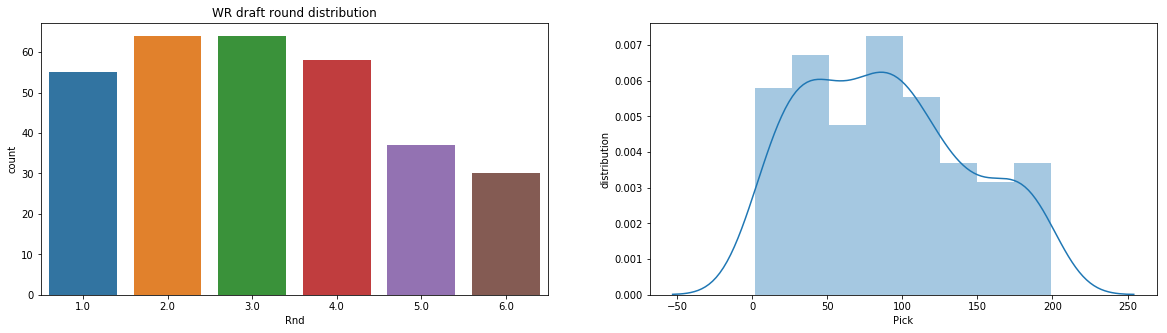

In [286]:
wr_data_merged['Rnd'] = wr_data_merged['Rnd'].astype(str).astype(float)
wr_data_merged['Pick'] = wr_data_merged['Pick'].astype(str).astype(float)

fig, ax = plt.subplots(figsize=(20,5))

plt.subplot(1,2,1)
sns.barplot(wr_data_merged.groupby(['Rnd']).size().index,
            [i for _,i in wr_data_merged.groupby(['Rnd']).size().items()])
plt.title('WR draft round distribution')
plt.ylabel('count')


plt.subplot(1,2,2)
sns.distplot(wr_data_merged['Pick'])
plt.ylabel('distribution')

plt.show()

In [287]:
#most of the data we are interested in are objects so we got to convert to floats
var_list = ['TD','40YD','Wt','Vertical','BenchReps','Shuttle','3Cone','Broad Jump']

for v in var_list:
    wr_data_merged[v] = wr_data_merged[v].astype(str).astype(float)
    
selected_data = wr_data_merged[['Rnd','Pick','TD','40YD','Wt','Vertical','BenchReps','Shuttle','3Cone','Broad Jump']].dropna()

In [288]:
selected_data.head()

,Rnd,Pick,TD,40YD,Wt,Vertical,BenchReps,Shuttle,3Cone,Broad Jump
2,6.0,195.0,75.0,4.56,186.0,33.5,13.0,4.18,6.98,105.0
6,1.0,4.0,63.0,4.48,211.0,34.5,18.0,4.21,6.91,126.0
10,3.0,84.0,57.0,4.33,199.0,40.0,14.0,4.27,6.90,129.0
12,1.0,6.0,55.0,4.34,220.0,38.5,17.0,4.25,6.66,135.0
15,3.0,78.0,51.0,4.54,207.0,34.0,22.0,4.20,7.06,119.0


In [289]:
#make X & Y values
X = selected_data.loc[:,[x for x in selected_data.columns if x != 'Pick' and x != 'Rnd']]
Y = selected_data['Rnd']

In [318]:
#select data
X_select_ = X.loc[:,[x for x in X.columns if x != 'TD' and x != 'Vertical' and x != 'BenchReps']]

#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_select_, Y, test_size = 0.5, random_state = 465)

#normalize the data
X_train, X_test = np.log10(X_train), np.log10(X_test)



X_train.head()

,40YD,Wt,Shuttle,3Cone,Broad Jump
250,0.656098,2.322219,0.612784,0.822822,2.079181
263,0.653213,2.290035,0.610660,0.832509,2.068186
39,0.646404,2.324282,0.637490,0.841985,2.100371
278,0.645422,2.303196,0.618048,0.825426,2.060698
151,0.652246,2.374748,0.648360,0.838219,2.075547


In [319]:
# print the shapes of X and y
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(61, 5)
(61,)
(61, 5)
(61,)


In [325]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

neighbors = KNeighborsClassifier(n_neighbors=5)


neighbors.fit(X_train,y_train)
y_pred = neighbors.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.07      0.12      0.09         8
         2.0       0.45      0.38      0.42        13
         3.0       0.18      0.23      0.20        13
         4.0       0.25      0.13      0.17        15
         5.0       0.09      0.20      0.13         5
         6.0       0.00      0.00      0.00         7

    accuracy                           0.20        61
   macro avg       0.17      0.18      0.17        61
weighted avg       0.21      0.20      0.20        61



/Users/patrickcullinane/anaconda3/envs/fast_ai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [321]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

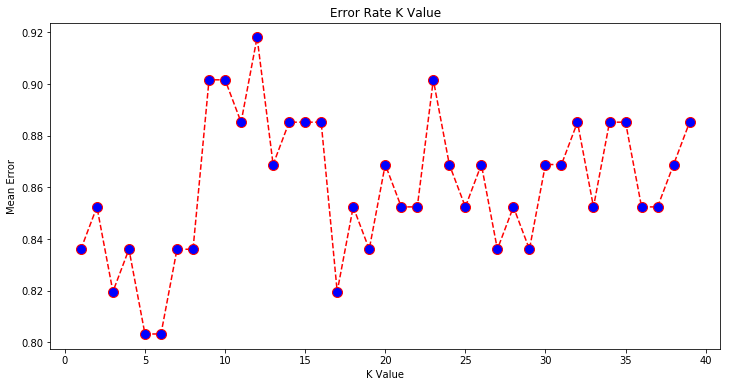

In [322]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [326]:
#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_train.head()

/Users/patrickcullinane/anaconda3/envs/fast_ai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,40YD,Wt,Shuttle,3Cone,Broad Jump
250,1.0,0.656098,2.322219,0.612784,0.822822,2.079181
263,1.0,0.653213,2.290035,0.610660,0.832509,2.068186
39,1.0,0.646404,2.324282,0.637490,0.841985,2.100371
278,1.0,0.645422,2.303196,0.618048,0.825426,2.060698
151,1.0,0.652246,2.374748,0.648360,0.838219,2.075547


In [327]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Rnd   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     3.036
Date:                Thu, 17 Oct 2019   Prob (F-statistic):             0.0172
Time:                        17:54:51   Log-Likelihood:                -100.34
No. Observations:                  61   AIC:                             212.7
Df Residuals:                      55   BIC:                             225.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.8492     29.352      2.720      0.0

#### Elasticnet

In [329]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

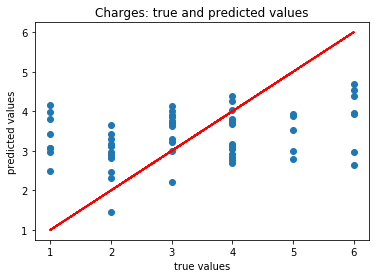

Best alpha value is: 0.0001
R^2 train 0.2019476191381303
-test stats-
R^2 test 0.07894985834039048
MAE prediction 1.2046217261070549
MSE prediction 2.087647647072601
RMSE prediction 1.4448694221529503
MA%E prediction 3.332948819174851


In [330]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

ElasticNetregrCV = ElasticNetCV(alphas=alphas, l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], cv=5)
ElasticNetregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = ElasticNetregrCV.predict(X_train)
y_preds_test = ElasticNetregrCV.predict(X_test)

#y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ElasticNetregrCV.alpha_))
print(f"R^2 train {ElasticNetregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {ElasticNetregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

#### Lasso 

In [331]:
from sklearn.linear_model import LassoCV

LassoregrCV = LassoCV(alphas=alphas, cv=5)
LassoregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = LassoregrCV.predict(X_train)
y_preds_test = LassoregrCV.predict(X_test)

print("Best alpha value is: {}".format(LassoregrCV.alpha_))
print(f"R^2 train {LassoregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {LassoregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 0.0001
R^2 train 0.21615346889161444
-test stats-
R^2 test 0.06360864100343788
MAE prediction 1.2196589052534805
MSE prediction 2.1224199736030656
RMSE prediction 1.4568527631861312
MA%E prediction 3.3399265603860284


#### Ridge

In [332]:
from sklearn.linear_model import RidgeCV

RidgeregrCV = RidgeCV(alphas=alphas, cv=5)
RidgeregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = RidgeregrCV.predict(X_train)
y_preds_test = RidgeregrCV.predict(X_test)

print("Best alpha value is: {}".format(RidgeregrCV.alpha_))
print(f"R^2 train {RidgeregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {RidgeregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 0.001
R^2 train 0.21487629842905143
-test stats-
R^2 test 0.06719535840502344
MAE prediction 1.2167813298018169
MSE prediction 2.114290337869399
RMSE prediction 1.4540599498883804
MA%E prediction 3.3367025853665218


/Users/patrickcullinane/anaconda3/envs/fast_ai/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Transform the data

In [28]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X_norm = X.copy()
names = X.columns
X_norm = scaler.fit_transform(X_norm)
X_norm = pd.DataFrame(X_norm, columns=names)

X_norm

,40YD,Wt,Vertical,BenchReps,Shuttle,3Cone,Broad Jump
0,1.121379,-1.077789,-0.743961,-0.363927,-0.294752,0.538722,-2.709800
1,0.202432,0.681984,-0.419227,0.774511,-0.085278,0.129772,0.698402
2,-1.520594,-0.162707,1.366812,-0.136239,0.333671,0.071351,1.185288
3,-1.405725,1.315503,0.879711,0.546824,0.194022,-1.330763,2.159060
4,0.891642,0.400421,-0.581594,1.685262,-0.155103,1.006093,-0.437665
...,...,...,...,...,...,...,...
117,1.006511,1.949021,-0.094492,1.229887,1.171569,0.012929,-0.924551
118,0.432169,-0.233098,0.230242,0.091448,-0.155103,1.122936,-0.599961
119,-1.405725,-2.485608,2.016281,-1.046990,1.799993,-2.031820,-0.924551
120,-1.750330,-0.937007,0.230242,0.091448,-0.504227,0.363458,-0.113075


In [29]:
#split
from sklearn.model_selection import train_test_split
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, Y, test_size = 0.2, random_state = 465)

#add constant
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

X_train_norm



/Users/patrickcullinane/anaconda3/envs/fast_ai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,40YD,Wt,Vertical,BenchReps,Shuttle,3Cone,Broad Jump
29,1.0,-1.865199,0.611593,0.879711,0.319136,-0.294752,-0.512863,0.698402
4,1.0,0.891642,0.400421,-0.581594,1.685262,-0.155103,1.006093,-0.437665
114,1.0,0.547037,0.822766,-0.419227,-0.363927,-0.085278,1.064515,0.049221
65,1.0,-1.750330,-1.359353,-0.419227,-0.591615,1.799993,0.713986,-0.599961
74,1.0,0.087564,-0.866616,0.230242,-0.819302,0.752620,0.129772,0.211516
...,...,...,...,...,...,...,...,...
39,1.0,0.202432,0.541203,-3.179469,0.091448,-0.015453,1.531886,-1.898323
53,1.0,-0.142173,-0.866616,0.392609,1.229887,-1.411950,-0.512863,-0.275370
11,1.0,-0.027305,-0.162707,-0.906328,1.685262,-0.783526,-0.454442,-1.573733
89,1.0,-0.257042,-0.021925,0.879711,-1.046990,-0.155103,-0.688128,0.536107


In [30]:
X_test_norm

,const,40YD,Wt,Vertical,BenchReps,Shuttle,3Cone,Broad Jump
30,1.0,-0.716515,-0.444271,0.067875,0.091448,-0.504227,-0.688128,-0.275370
2,1.0,-1.520594,-0.162707,1.366812,-0.136239,0.333671,0.071351,1.185288
101,1.0,1.351116,-1.992872,-1.231063,-1.730053,1.031920,-0.454442,-0.762256
15,1.0,1.236247,0.752375,-0.256860,0.774511,-0.643877,-0.512863,0.698402
110,1.0,0.087564,0.189248,-0.094492,-1.046990,-0.923176,-1.097078,1.672174
117,1.0,1.006511,1.949021,-0.094492,1.229887,1.171569,0.012929,-0.924551
62,1.0,-0.486778,-0.937007,1.204445,-0.363927,-0.643877,-0.220756,0.049221
108,1.0,-0.946252,0.330030,-0.581594,1.685262,-0.853351,-1.213921,1.509879
85,1.0,-1.520594,1.878631,1.529179,2.823700,1.939643,2.875579,1.996765
71,1.0,-2.094935,-1.077789,-0.743961,0.091448,1.520694,0.655565,-1.086847


In [31]:
y_test_norm

78     15.0
10     57.0
252     1.0
46     26.0
275     0.0
297     0.0
165     5.0
272     0.0
221     2.0
191     3.0
300     0.0
222     2.0
129     8.0
284     0.0
32     33.0
169     5.0
251     1.0
243     1.0
84     14.0
43     28.0
122     9.0
108    11.0
70     17.0
180     4.0
193     3.0
Name: TD, dtype: float64

In [32]:
# We fit an OLS model using statsmodels
results = sm.OLS(list(y_train_norm), X_train_norm).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.7415
Date:                Thu, 17 Oct 2019   Prob (F-statistic):              0.637
Time:                        09:09:25   Log-Likelihood:                -398.29
No. Observations:                  97   AIC:                             812.6
Df Residuals:                      89   BIC:                             833.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8652      1.560      7.606      0.0

In [33]:
from sklearn.linear_model import LassoCV

LassoregrCV = LassoCV(alphas=alphas, cv=5)
LassoregrCV.fit(X_train_norm, y_train_norm)

#prediction time
y_preds_train = LassoregrCV.predict(X_train)
y_preds_test = LassoregrCV.predict(X_test)

print("Best alpha value is: {}".format(LassoregrCV.alpha_))
print(f"R^2 train {LassoregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {LassoregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 1e+39
R^2 train 0.0
-test stats-
R^2 test -0.02364469322263618
MAE prediction 10.616494845360826
MSE prediction 182.94577957274953
RMSE prediction 13.52574506534666
MA%E prediction 10.82783505154639


##### KNN classifier 

In [50]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

Y = selected_data['TD']
X_norm = selected_data.loc[:,[x for x in selected_data.columns if x != 'TD']]

names = X_norm.columns
X_norm = scaler.fit_transform(X_norm)
X_norm = pd.DataFrame(X_norm, columns=names)

X_norm.head()

,40YD,Wt,Vertical,BenchReps,Shuttle,3Cone,Broad Jump
0,1.121379,-1.077789,-0.743961,-0.363927,-0.294752,0.538722,-2.709800
1,0.202432,0.681984,-0.419227,0.774511,-0.085278,0.129772,0.698402
2,-1.520594,-0.162707,1.366812,-0.136239,0.333671,0.071351,1.185288
3,-1.405725,1.315503,0.879711,0.546824,0.194022,-1.330763,2.159060
4,0.891642,0.400421,-0.581594,1.685262,-0.155103,1.006093,-0.437665


In [56]:
#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size = 0.4, random_state = 4)



In [57]:
#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_train.head()

,const,40YD,Wt,Vertical,BenchReps,Shuttle,3Cone,Broad Jump
15,1.0,1.236247,0.752375,-0.256860,0.774511,-0.643877,-0.512863,0.698402
89,1.0,-0.257042,-0.021925,0.879711,-1.046990,-0.155103,-0.688128,0.536107
95,1.0,0.202432,-0.585053,-0.094492,0.774511,0.333671,-0.279178,0.536107
71,1.0,-2.094935,-1.077789,-0.743961,0.091448,1.520694,0.655565,-1.086847
51,1.0,0.776774,0.118857,-0.581594,-1.046990,-0.085278,-0.688128,-1.736028


In [58]:
# print the shapes of X and y
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(73, 8)
(73,)
(49, 8)
(49,)


In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
neighbors = KNeighborsClassifier(n_neighbors=1)

X = X_train_norm
Y = y_train_norm
neighbors.fit(X,Y)
y_pred = neighbors.predict(X)
print(metrics.accuracy_score(Y, y_pred))

0.9896907216494846


In [74]:
neighbors = KNeighborsClassifier(n_neighbors=4)

X = X_train_norm
Y = y_train_norm
neighbors.fit(X,Y)
y_pred = neighbors.predict(X)
print(metrics.accuracy_score(Y, y_pred))

0.4020618556701031


In [75]:
#Hypothetical examples with an athlete & the following parameters

example = [1.0,4.5,215,35,15,6.98,4.5,120]
np.log10(example)


print(neighbors.predict([np.log10(example)]))

[2.]


#### Future work/Summary

It would be interesting to to see if a division 1 school 